In [56]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

In [57]:
data = pd.read_csv("train.csv")

In [58]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [59]:
data = data.dropna()

In [60]:
X = data.drop(columns='label')
y = data['label']

In [61]:
import tensorflow as tf 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout

In [62]:
messages = X.copy()
messages['title'][10]

'Obama’s Organizing for Action Partners with Soros-Linked ‘Indivisible’ to Disrupt Trump’s Agenda'

In [63]:
messages.reset_index(inplace=True)

In [64]:
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Quadeer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
vocab_size = 10000

In [66]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

    print(f"\rProgress: {i+1}",end='')

Progress: 18285

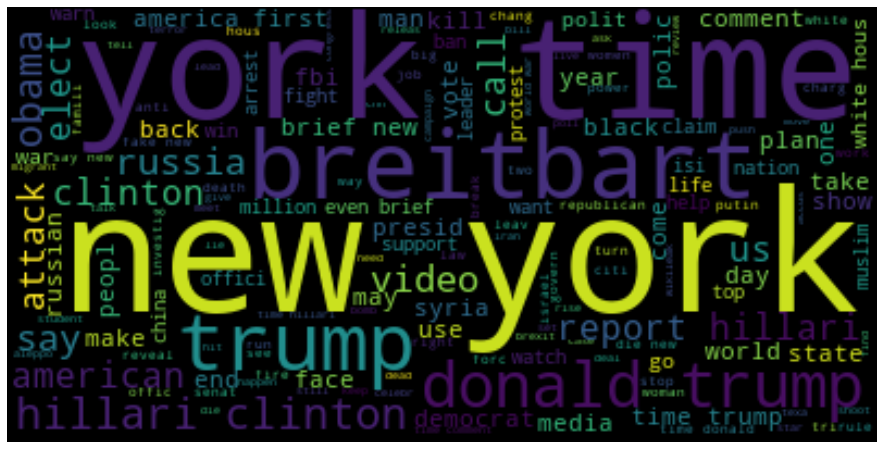

In [97]:
wordcloud = WordCloud().generate(" ".join(corpus))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [67]:
onehot_enc=[one_hot(words,vocab_size)for words in corpus] 

In [68]:
lengths = []
for enc in onehot_enc:
    lengths.append(len(enc))

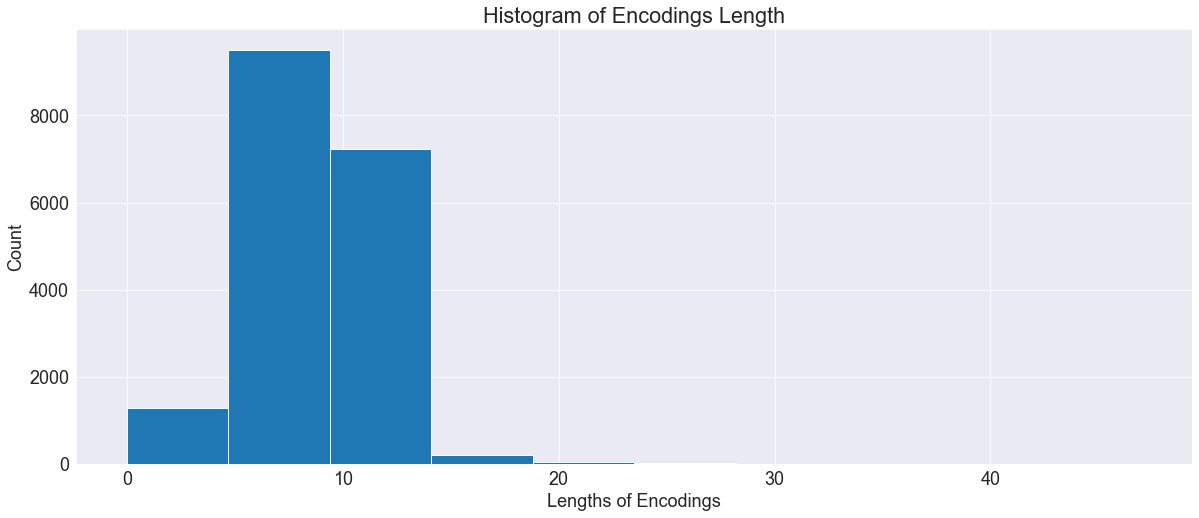

In [69]:
plt.hist(lengths,)
plt.xlabel("Lengths of Encodings")
plt.ylabel("Count")
plt.title("Histogram of Encodings Length")
plt.show()

In [70]:
sentence_length=25
embedded_docs=pad_sequences(onehot_enc,padding='pre',maxlen=sentence_length)
print(embedded_docs)

[[   0    0    0 ... 4850 8266 9335]
 [   0    0    0 ... 6338 5327 1591]
 [   0    0    0 ... 8846 2130 2415]
 ...
 [   0    0    0 ... 1526 5759 8926]
 [   0    0    0 ... 4265 8793  842]
 [   0    0    0 ...  929 1794 5294]]


In [71]:
emb_model = Sequential()
emb_model.add(Embedding(vocab_size,50,input_length=sentence_length))
emb_model.compile('adam','mse')

In [72]:
emb_model.predict(embedded_docs)[0].shape

(25, 50)

In [73]:
embedding_vector_features=50
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sentence_length))
model.add(LSTM(10))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 50)            500000    
                                                                 
 lstm (LSTM)                 (None, 10)                2440      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 502,451
Trainable params: 502,451
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
X_full = np.array(embedded_docs)
y_full = np.array(y)

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.20, random_state=42)

In [76]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64)

Epoch 1/50
229/229 [==============================] - 6s 14ms/step - loss: 0.6863 - accuracy: 0.6899 - val_loss: 0.6799 - val_accuracy: 0.7492
Epoch 2/50
229/229 [==============================] - 3s 13ms/step - loss: 0.6718 - accuracy: 0.7460 - val_loss: 0.6636 - val_accuracy: 0.7304
Epoch 3/50
229/229 [==============================] - 3s 14ms/step - loss: 0.6519 - accuracy: 0.7414 - val_loss: 0.6406 - val_accuracy: 0.7348
Epoch 4/50
229/229 [==============================] - 3s 13ms/step - loss: 0.6241 - accuracy: 0.7437 - val_loss: 0.6087 - val_accuracy: 0.7533
Epoch 5/50
229/229 [==============================] - 3s 13ms/step - loss: 0.5876 - accuracy: 0.7868 - val_loss: 0.5686 - val_accuracy: 0.7996
Epoch 6/50
229/229 [==============================] - 3s 13ms/step - loss: 0.5429 - accuracy: 0.8344 - val_loss: 0.5215 - val_accuracy: 0.8491
Epoch 7/50
229/229 [==============================] - 3s 13ms/step - loss: 0.4922 - accuracy: 0.8711 - val_loss: 0.4728 - val_accuracy: 0.8605

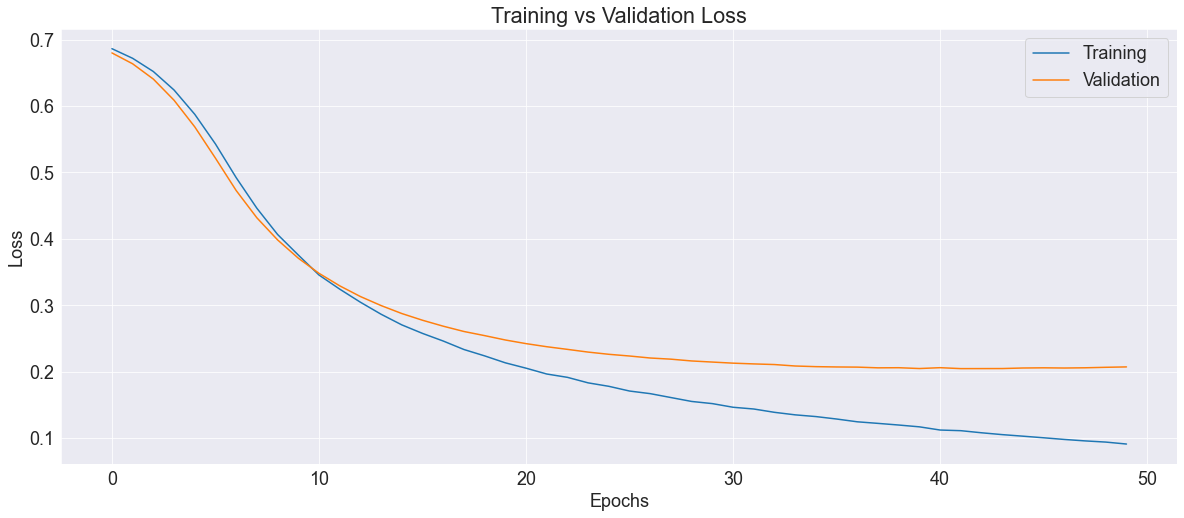

In [77]:
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

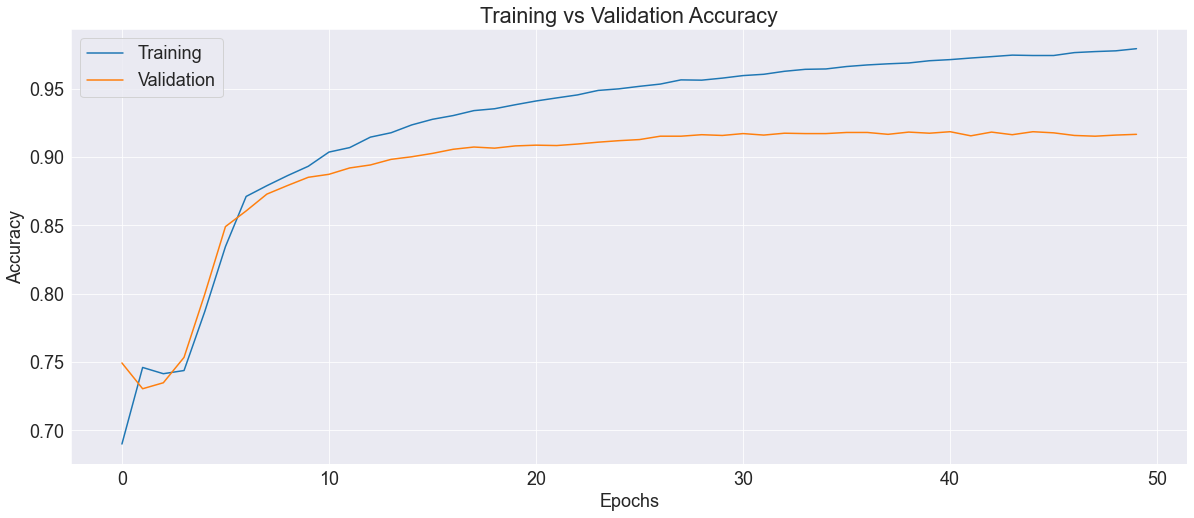

In [78]:
plt.plot(history.history['accuracy'],label='Training')
plt.plot(history.history['val_accuracy'],label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [79]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [80]:
y_pred = model.predict(X_test)

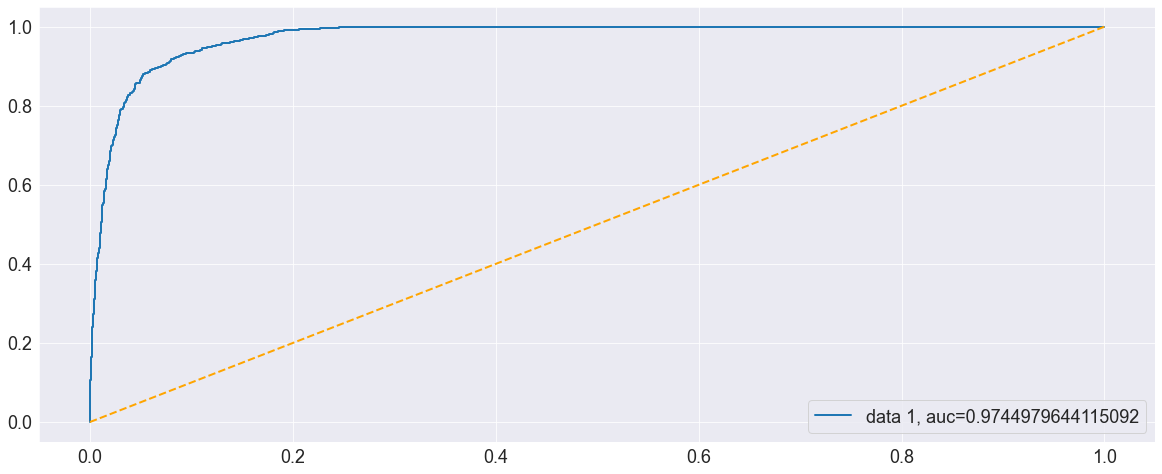

In [81]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [82]:
y_pred = model.predict(X_test)
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2082
           1       0.90      0.90      0.90      1575

    accuracy                           0.92      3657
   macro avg       0.92      0.91      0.91      3657
weighted avg       0.92      0.92      0.92      3657



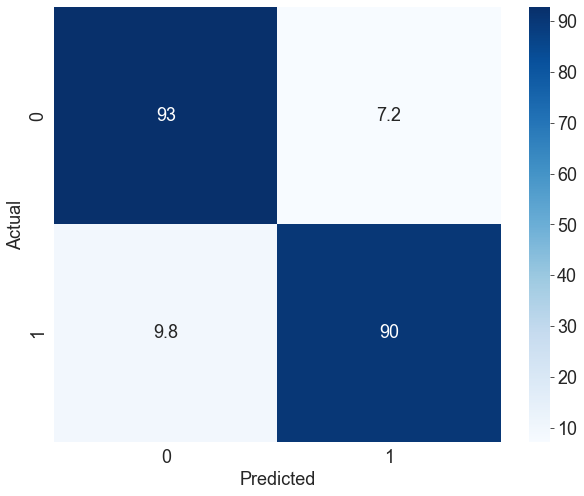

In [90]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize='true')*100,annot=True,cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [102]:
from tensorflow.keras.datasets import reuters, imdb, cifar10

(train_data,train_labels),(test_data,test_labels) = cifar10.load_data()

In [103]:
train_data, test_data = train_data / 255. , test_data / 255.

In [104]:
train_data.shape

(50000, 32, 32, 3)

In [105]:
test_data.shape

(10000, 32, 32, 3)

In [106]:
train_data = train_data.reshape(50000,-1)
test_data = test_data.reshape(10000,-1)

In [108]:
from sklearn.decomposition import PCA
import time

In [109]:
start_time = time.time()
pca = PCA()
pca.fit(train_data)

train_pca = pca.transform(train_data)

print(time.time()-start_time)

128.40873456001282


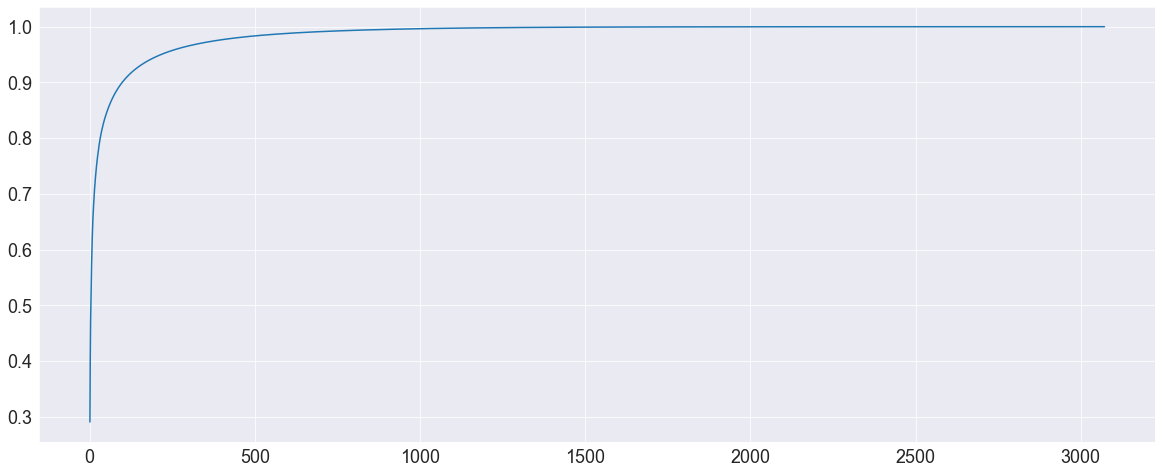

In [110]:
x = np.arange(1,3073,1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(x,y)

In [111]:
X_train = train_pca[:,:1000]
y_train = train_labels

In [112]:
X_test = pca.transform(test_data)[:,:1000]
y_test = test_labels

In [113]:
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [117]:
model = Sequential([
        Dense(32, activation="relu",input_shape=(X_train.shape[1], )),
        Dense(10, activation="softmax")
        ])

In [118]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [119]:
model.fit(X_train,y_train,batch_size=64,validation_data=(X_test,y_test),validation_batch_size=64,epochs=50)

Epoch 1/50
782/782 [==============================] - 2s 2ms/step - loss: 1.7804 - accuracy: 0.3751 - val_loss: 1.6045 - val_accuracy: 0.4397
Epoch 2/50
782/782 [==============================] - 1s 1ms/step - loss: 1.5155 - accuracy: 0.4759 - val_loss: 1.5346 - val_accuracy: 0.4593
Epoch 3/50
782/782 [==============================] - 1s 1ms/step - loss: 1.4184 - accuracy: 0.5075 - val_loss: 1.5214 - val_accuracy: 0.4646
Epoch 4/50
782/782 [==============================] - 1s 1ms/step - loss: 1.3552 - accuracy: 0.5301 - val_loss: 1.5069 - val_accuracy: 0.4653
Epoch 5/50
782/782 [==============================] - 1s 1ms/step - loss: 1.3075 - accuracy: 0.5450 - val_loss: 1.5097 - val_accuracy: 0.4671
Epoch 6/50
782/782 [==============================] - 1s 2ms/step - loss: 1.2706 - accuracy: 0.5561 - val_loss: 1.5098 - val_accuracy: 0.4663
Epoch 7/50
782/782 [==============================] - 1s 1ms/step - loss: 1.2386 - accuracy: 0.5680 - val_loss: 1.5200 - val_accuracy: 0.4673
Epoch 

KeyboardInterrupt: 

In [186]:
def vectorize_sequences(sequences, dimension=10000):
    # Creating an all-zero matrix of shape
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            # Seting specific indices of results[i] to 1s
            results[i, j] = 1. 
    return results

In [187]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data) 

In [188]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [196]:
y_train = y_train[:,0]
y_test = y_test[:,0]

In [214]:
from sklearn.decomposition import PCA 

In [221]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu",input_shape=(x_train.shape[1], )),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [222]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [223]:
model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test,y_test), validation_batch_size=64)

Epoch 1/50
391/391 [==============================] - 36s 75ms/step - loss: 0.4748 - accuracy: 0.8037 - val_loss: 0.3100 - val_accuracy: 0.8808
Epoch 2/50
391/391 [==============================] - 6s 14ms/step - loss: 0.2377 - accuracy: 0.9118 - val_loss: 0.2825 - val_accuracy: 0.8866
Epoch 3/50
391/391 [==============================] - 4s 11ms/step - loss: 0.1780 - accuracy: 0.9364 - val_loss: 0.2979 - val_accuracy: 0.8808
Epoch 4/50
391/391 [==============================] - 5s 12ms/step - loss: 0.1416 - accuracy: 0.9505 - val_loss: 0.3106 - val_accuracy: 0.8800
Epoch 5/50
391/391 [==============================] - 5s 14ms/step - loss: 0.1108 - accuracy: 0.9642 - val_loss: 0.3414 - val_accuracy: 0.8762
Epoch 6/50
336/391 [========================>.....] - ETA: 0s - loss: 0.0855 - accuracy: 0.9736

KeyboardInterrupt: 

In [145]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

In [146]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "") for i in
    train_data[12]])

In [148]:
len(train_data)

8982

In [149]:
news = []
for i in range(len(train_data)):
    word_index = reuters.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decoded_newswire = " ".join([reverse_word_index.get(i - 3, "") for i in train_data[i]])
    news.append(decoded_newswire)

KeyboardInterrupt: 

In [151]:
len(news)

5563

In [124]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [125]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [127]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [135]:
model = Sequential([
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(46, activation="softmax")
])

In [136]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [137]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [138]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 125ms/step - loss: 3.2294 - accuracy: 0.4689 - val_loss: 2.4329 - val_accuracy: 0.5470
Epoch 2/20
16/16 [==============================] - 1s 37ms/step - loss: 1.9018 - accuracy: 0.6185 - val_loss: 1.6082 - val_accuracy: 0.6620
Epoch 3/20
16/16 [==============================] - 0s 24ms/step - loss: 1.3288 - accuracy: 0.7140 - val_loss: 1.2873 - val_accuracy: 0.7090
Epoch 4/20
16/16 [==============================] - 0s 28ms/step - loss: 1.0204 - accuracy: 0.7751 - val_loss: 1.1243 - val_accuracy: 0.7520
Epoch 5/20
16/16 [==============================] - 0s 27ms/step - loss: 0.7952 - accuracy: 0.8307 - val_loss: 1.0241 - val_accuracy: 0.7910
Epoch 6/20
16/16 [==============================] - 0s 24ms/step - loss: 0.6190 - accuracy: 0.8706 - val_loss: 0.9523 - val_accuracy: 0.8060
Epoch 7/20
16/16 [==============================] - 0s 21ms/step - loss: 0.4787 - accuracy: 0.8994 - val_loss: 0.9073 - val_accuracy: 0.8170
Epoch 8/20
1

https://medium.com/@nutanbhogendrasharma/sentiment-classification-with-bidirectional-lstm-on-imdb-dataset-1ab21e6eeee9

https://www.tensorflow.org/tutorials/images/data_augmentation